In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import glob
import csv
from datetime import datetime

from subprocess import Popen
from multiprocessing import Pool

# Creating points on a sphere 

In [20]:
# Inputs
theta_max = 40      # angle above horizontal (0-90 deg)
theta_min = 70      # angle below horizontal (0-90 deg, can be positive or negative)
n = 25000             # n = number of points on the sphere (full sphere, before cutting off range of vision)
 
golden_angle = np.pi * (3 - np.sqrt(5))
theta = golden_angle * np.arange(n)      # create an array with n elements
z = np.linspace(1 - 1.0 / n, 1.0 / n - 1, n)     # array with linear spacing from 1-1/n to 1/n-1 with n elements 
radius = np.sqrt(1 - z * z)
 
#selectTheta = np.array[(theta > theta.min) & (theta < theta.max)]

# Create points = array of n elements with [0, 0, 0]
points = np.zeros((n, 3))

points[:,0] = radius * np.cos(theta)
points[:,1] = radius * np.sin(theta)
points[:,2] = z

#select only points within range of vision
angle_max = abs(theta_max)/90
angle_min = -abs(theta_min)/90
selectPts = np.delete(points, np.where(np.logical_or(points[:,2]>angle_max, points[:,2]<=angle_min)), axis=0)

print(selectPts.shape)

# Convert the rays array to dataframe
all_rays_df = pd.DataFrame(selectPts)


(15278, 3)


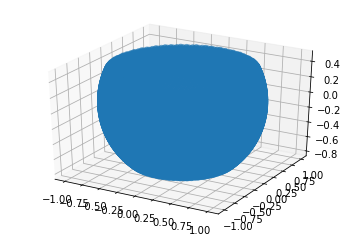

In [21]:
# Plot test
pts_x = selectPts[:,0]
pts_y = selectPts[:,1]
pts_z = selectPts[:,2]
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(pts_x, pts_y, pts_z)
plt.show()

# Move grid points up (not needed each time -> uncomment if need to run) 
[uncomment shortcut: ctrl + /] 

In [9]:
# # Inputs to move pts up by Z amount
# sourceDir = r"D:\ituran\NYCviews\BINS_test"
# zMove = 3

# # Remove any existing revised pts files (ONLY NEEDED IF RERUNNING SCRIPT BELOW)
# for path, subdir, files in os.walk(sourceDir):
#     # Remove any older revised pt files created
#     for name in files: 
#         if name.endswith('_all_5.pts'):
#             print('delete', name)
#             os.remove(os.path.join(path, name))
#         else: 
#             print('all clear in', path) 
            
# # Loop through all BINS and write new pts file at new height            
# for BIN in os.listdir(sourceDir):    
#     #Make list of all .pts file in directory
#     os.chdir(sourceDir + "\\" + BIN)

#     newPtsFile = sourceDir + "\\" + BIN + "\\" + BIN + '_all_5.pts'   
#     all_lines = []
#     for file in glob.glob("*.pts"): 
#         # Read .pts file into list and convert to DF
#         with open(sourceDir + "\\" + BIN + "\\" + file) as f: 
#             lines = f.readlines()
#         lines = [x.strip() for x in lines]
#         for i in range(len(lines)): 
#             oneRow = list(map(float, lines[i].split()))

#             # Move Z up by specified amount
#             oneRow[2] = oneRow[2] + zMove

#             all_lines.append(oneRow)

#     # Write a new .pts file with all of the updated points 
#     stringList = []
#     for line in all_lines: 
#         line[3:6] = map(int, line[3:6])
#         newLine = ' '.join(str(x) for x in line)
#         stringList.append(newLine)
        
#     with open(newPtsFile, 'w') as out: 
#         out.write('\n'.join(stringList))
  

# Functions for prepping BIN Directories

In [10]:
############################################
#### NEW 200320 for the moved Z points! #### 
############################################

# FUNCTION: Set up rays for applying to the floors
def setUpRaysforMerge(ray_vec_df): 
    #Create same column for merging in both sets 
    ray_vec_df['ray_count'] = ray_vec_df.index
    
    return(ray_vec_df)
    
# FUNCTION: Concatenate all the pts for all floors into one dataframe
def concatenateAllPtsMoved(sourceDir, BIN):
   
    #sourceDir: the directory for all BIN folders
    #BIN: name of BIN (string)

    #Make list of all .pts file in directory
    os.chdir(sourceDir + "\\" + BIN)
    all_lines = []
    
    for file in glob.glob("*_all_5.pts"): 
        # Read .pts file into list and convert to DF
        with open(sourceDir + "\\" + BIN + "\\" + file) as f: 
            lines = f.readlines()
        lines = [x.strip() for x in lines]
        for i in range(len(lines)): 
            oneRow = list(map(float, lines[i].split()))
            del oneRow[-3:]
            all_lines.append(oneRow)

    #Create dataframe with points for all floors in BIN
    BIN_pts_df = pd.DataFrame(all_lines)
    BIN_pts_df.columns = ["x", "y", "z"]

    #print(BIN_pts_df.head())
    print("---> # of points in all floors in BIN (# rows):", BIN_pts_df.shape)
    #print(BIN_pts_df.shape)

    #Check that all floors are represented
    #print("z value of all floors:")
    #print(BIN_pts_df["z"].unique())
    
    return(BIN_pts_df)

# FUNCTION: Create the rays for each point in the BIN grids
def createGridRaysNew(rays_forMerge, BIN_pts_df):

    # rays_forMerge: the rays to trace in a dataframe set up for merge from setUpRaysforMerge
    # BIN_pts_df: all points in the BIN in a dataframe
    
    print('>>RAYS:', rays_forMerge.shape)
    print('>>BIN PTS:', BIN_pts_df.shape)
    
    # Duplicate each row of grid point df by size of vector df and add ray index column
    vectors_df = pd.DataFrame(np.repeat(BIN_pts_df.values, len(rays_forMerge.index), axis=0))
    vectors_df['ray_count'] = vectors_df.groupby([0, 1, 2]).cumcount()
    vectors_df = vectors_df.reset_index(drop=True)  
    
    # Check that the rows are being counted correctly
    print('>>VECTOR SHAPE:', vectors_df.shape)   
    #print(vectors_df.iloc[6109:6114,:])
    #print(vectors_df.iloc[1998290:1998305,:])
         
    # Merge the dfs based on the ray_count 
    all_floor_vectors = pd.merge(vectors_df, rays_forMerge, how = 'left', on = 'ray_count')
    all_floor_vectors = all_floor_vectors.drop(['ray_count'], axis=1)
    print('>>BIN RAYS SHAPE:', all_floor_vectors.shape)
    
    #print(all_floor_vectors.head())
    #print(all_floor_vectors.iloc[6109:6114,:])
    #print(all_floor_vectors.iloc[1998290:1998305,:])
    
    return(all_floor_vectors)
    
# FUNCTION: Export dataframe to CSV (TAKES A LONG TIME -- V BIG FILES!)
def writeGridRaystoCSV(grid_vectors, sourceDir, BIN):

    #grid_vectors: the output from createGridRays
    #sourceDir: the directory for all BIN folders
    #BIN: name of BIN (string)
    
    print("---> WRITE_START:", datetime.now())
    csvFile = sourceDir + "\\" + BIN + "\\" + BIN + "_rays.csv"
    grid_vectors.to_csv(csvFile, sep=" ", header=False, index=False)
    print("---> WRITE_END:", datetime.now())

    # Check the file size
    size = os.path.getsize(csvFile)
    print("---> csv file size: " + str(size/1e+6) + "mb")

# FUNCTION: Plot test the grid vectors 
def plotGridVectorsTest(grid_vectors):
    
    #Take a small portion of the vectors 
    grid_slice = grid_vectors.truncate(after=600)

    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(grid_slice["0_x"], grid_slice["1_x"], grid_slice["2_x"], grid_slice["0_y"], grid_slice["1_y"], grid_slice["2_y"])

    #ax.set_zlim(-1.01, 1.01)

    ax.view_init(azim=0, elev=90)
    plt.show()


# Create csv with ray for full floor analysis grid --- all floors in BIN

In [ ]:
# 200320 REDO LOOP TO RECREATE RAYS FOR MOVED Z POINTS 
NYCsourceDir = r'D:\ituran\NYCviews\BINS_test_2'

# Set up rays for merge with BIN floors 
rays_forMerge = setUpRaysforMerge(all_rays_df)
#print(rays_forMerge.head())

# Loop through all BINS in directory 
for file in os.listdir(NYCsourceDir): 
    print("---")
    print(file+"_START", datetime.now())
    
    print(file + "_1 concatenate all points in BIN")
    # made dataframe with the points on all floors in the BIN
    allflr_pt_df = concatenateAllPtsMoved(NYCsourceDir, file)

    print(file + "_2 make vector for all points in BIN")
    # apply vector rays to all points on all floors in the BIN
    allflr_vector_df = createGridRaysNew(rays_forMerge, allflr_pt_df)
    
    print(file + "_3 write vector df to CSV")
    # write the vector array to a file
    writeGridRaystoCSV(allflr_vector_df, NYCsourceDir, file)

    print(file+"_END", datetime.now())
    print("---")


---
1034228_START 2020-04-01 10:00:10.443565
1034228_1 concatenate all points in BIN
---> # of points in all floors in BIN (# rows): (442, 3)
1034228_2 make vector for all points in BIN
>>RAYS: (15278, 4)
>>BIN PTS: (442, 3)
>>VECTOR SHAPE: (6752876, 4)
>>BIN RAYS SHAPE: (6752876, 6)
1034228_3 write vector df to CSV
---> WRITE_START: 2020-04-01 10:00:14.030564


# Create batch file in each BIN folder

In [13]:
#BINSourceDir = r'D:\ituran\NYCviews\BINS_1'
#BINSourceDir = r'D:\ituran\NYCviews\BINS_2'
#BINSourceDir = r'D:\ituran\NYCviews\BINS_3'
BINSourceDir = r'D:\ituran\NYCviews\BINS_test_2'

source_batch = r"D:\ituran\NYCviews\SimFiles\views_batch_master_D.bat"

# New input text
input_scene_cd = r'D:\ituran\NYCviews\RadScene'
input_oct = r'D:\ituran\NYCviews\RadScene\NYCmodel_all_wSkyandViews_200124.oct'

for file in os.listdir(BINSourceDir): 
    
    # Read the source batch file template
    with open(source_batch, "r") as f: 
        sourceFile = f.readlines()

    for i in range(len(sourceFile)): 
        sourceFile[i] = sourceFile[i].replace('cd', 'cd ' + input_scene_cd)
        sourceFile[i] = sourceFile[i].replace('set octreefile=', 'set octreefile=' + input_oct)
        sourceFile[i] = sourceFile[i].replace('set rayFile=', 'set rayFile=' + BINSourceDir + '\\' + file + '\\' + file + '_rays.csv')
        sourceFile[i] = sourceFile[i].replace('set resultsFile=', 'set resultsFile=' + BINSourceDir + '\\' + file + '\\' + file + '_out.dat')

    newBat = BINSourceDir + '\\' + file + '\\' 'view_batch_d.bat'
    with open(newBat, 'w') as out: 
        for i in sourceFile: 
            out.write(i)
            
    print('BIN batch complete:', file)

                                          

BIN batch complete: 1034228
BIN batch complete: 1034235
BIN batch complete: 1034237
BIN batch complete: 1034240
BIN batch complete: 1034242


# Create loop for the batch simulations
NOTE: Doesn't run in Jupyter. Running it in Spyder (PY file: D:\ituran\NYCviews\SimFiles\NYCviews_simulationLoop.py)
    

# OLD CODE BELOW!